In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('census_income')

In [3]:
# Remove nulls

# Replace ? with np.nan
X.replace({'workclass': {'?': np.nan},
           'occupation': {'?': np.nan},
           'native-country': {'?': np.nan}}, 
           inplace=True)

r, _ = np.where(pd.isnull(X))

idx = [i for i in range(X.shape[0]) if i not in r]
X = X.iloc[idx, :]
y = y.iloc[idx, :]

In [4]:
# Filter to USA and remove columns capital-loss, capital-gain
r = np.where(X['native-country']=='United-States')
X = X.iloc[r[0], :].copy()
y = y.iloc[r[0], :].copy()

excl_col = ['native-country', 'capital-loss', 'capital-gain']
X.drop(columns=excl_col, inplace=True)

In [5]:
# update the metadata
variables = variables.query('name not in @excl_col')

In [6]:
# This is an imbalanced dataset 
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

y.replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
y.value_counts(normalize=True)

income
<=50K     0.746973
>50K      0.253027
Name: proportion, dtype: float64

In [7]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [8]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                age
2             fnlwgt
4      education-num
12    hours-per-week
Name: name, dtype: object

In [9]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

1         workclass
3         education
5    marital-status
6        occupation
7      relationship
8              race
9               sex
Name: name, dtype: object

# Train SVM

In [10]:

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
# cat_pipeline = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
# ])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    # ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

clf = SVC(random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



## Tune the SVM

In [15]:
cv_scores = []

grid_params = {
        'kernel': {'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}, 
        'gamma': {'model__gamma':[1e-2, 1e-3, 1e-4, 1e-5]},
        'C': {'model__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
    }
for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf_pipeline, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_train, y_train.values.ravel())

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_test_score': gs.cv_results_['mean_test_score'],
                                   'mean_train_score': gs.cv_results_['mean_train_score'],
                                   }))

cv_scores = pd.concat(cv_scores)

------------------ kernel ------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
------------------ gamma ------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
------------------ C ------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [13]:
cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=3, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

KeyError: "The following 'value_vars' are not present in the DataFrame: ['mean_test_score', 'mean_train_score']"

In [ ]:
grid_params = {
        'model__kernel': ['poly', ], 
        'model__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
        'model__C': [0.10, 0.2, 0.3],
    }

    
gs = GridSearchCV(clf_pipeline, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_train, y_train.values.ravel())

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score of train set: 0.7603014967611348
Best parameter set: {'model__C': 0.2, 'model__gamma': 1e-05, 'model__kernel': 'poly'}
Test Score: 0.7681317350768858


In [ ]:
gs.best_estimator_['model']

SVC(C=0.2, gamma=1e-05, kernel='poly', random_state=42)

In [ ]:
import joblib
joblib.dump(value=gs, filename='./model/svm_census_income_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/svm_census_income_best.pkl', compress=True)

['./model/svm_census_income_best.pkl']

In [ ]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

[learning_curve] Training set sizes: [ 2642  5285  7927 10570 13213 15855 18498 21140 23783 26426]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  50 | elapsed:    5.4s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:   13.6s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.1s finished


<Axes: xlabel='train_size_abs', ylabel='value'>

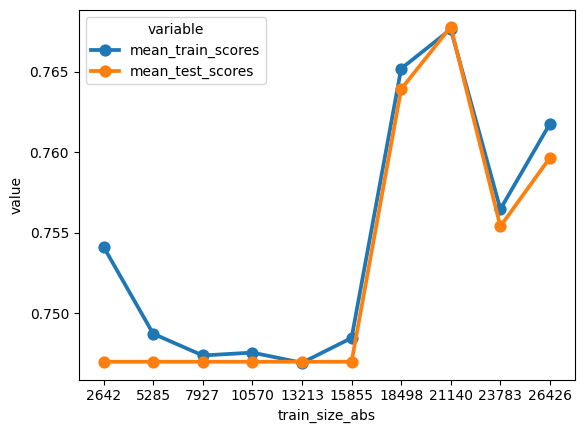

In [ ]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

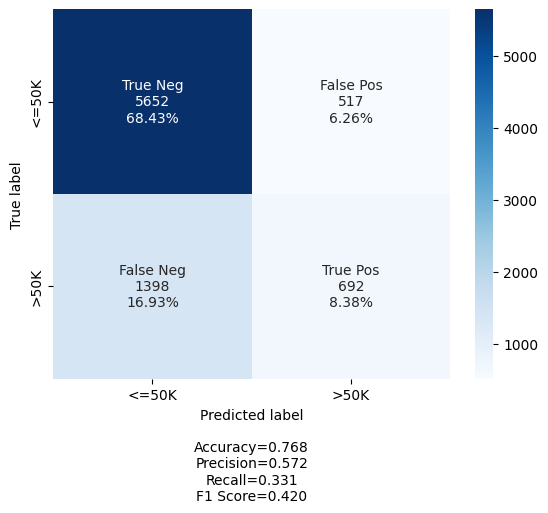

In [ ]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['<=50K', '>50K'], cmap='Blues')

In [ ]:

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions, pos_label='>50K'),
          'recall_score':recall_score(y_test, y_test_predictions, pos_label='>50K'),
          'f2_score':fbeta_score(y_test, y_test_predictions, beta=2, pos_label='>50K')
}

print(scores)

{'accuracy_score': 0.7681317350768858, 'precision_score': 0.5723738626964433, 'recall_score': 0.3311004784688995, 'f2_score': 0.3615842825791619}


In [ ]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


              precision    recall  f1-score   support

       <=50K       0.80      0.92      0.86      6169
        >50K       0.57      0.33      0.42      2090

    accuracy                           0.77      8259
   macro avg       0.69      0.62      0.64      8259
weighted avg       0.74      0.77      0.74      8259



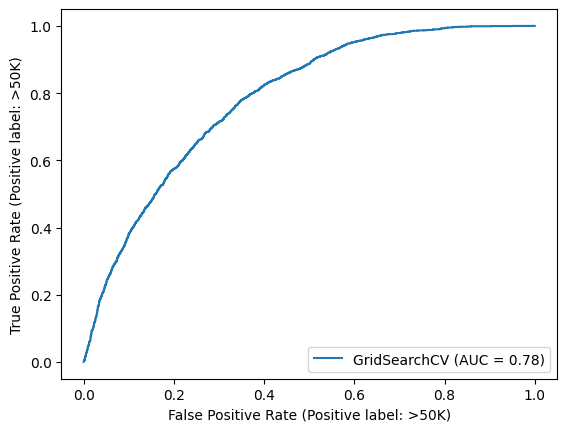

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, )
plt.show()

In [ ]:
# plot precison recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_test, y_test_predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

ValueError: y_true takes value in {'<=50K', '>50K'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.